In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

In [16]:
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/My Drive/data/Khairul Islam - diabetes-data.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

print("\nClass Distribution:")
print(df['Outcome'].value_counts())
print(f"Diabetes prevalence: {df['Outcome'].mean():.2%}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Overview:
Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']

First few rows:
   Pregnancies  Glucose  Blood Pressure  Skin Thickness  Insulin   BMI  \
0            6      148              72              35        0  33.6   
1            1       85              66              29        0  26.6   
2            8      183              64               0        0  23.3   
3            1       89              66              23       94  28.1   
4            0      137              40              35      168  43.1   

   DiabetesPedigree  Age  Outcome  
0             0.627   50        1  
1             0.351   31        0  
2             0.672   32        1  
3             0.167   21        0  
4             2.288   33        1  

Basic Statistics:
       Pregn

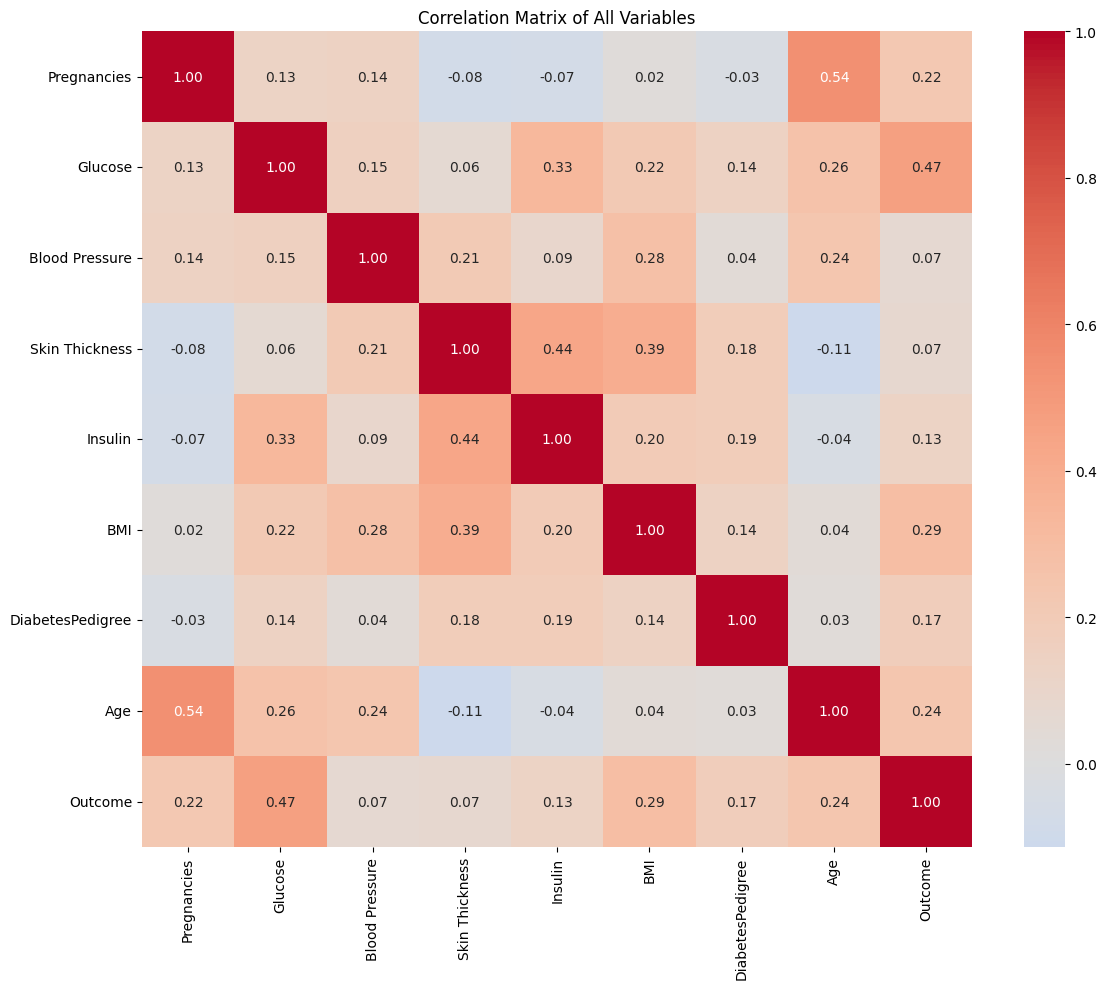

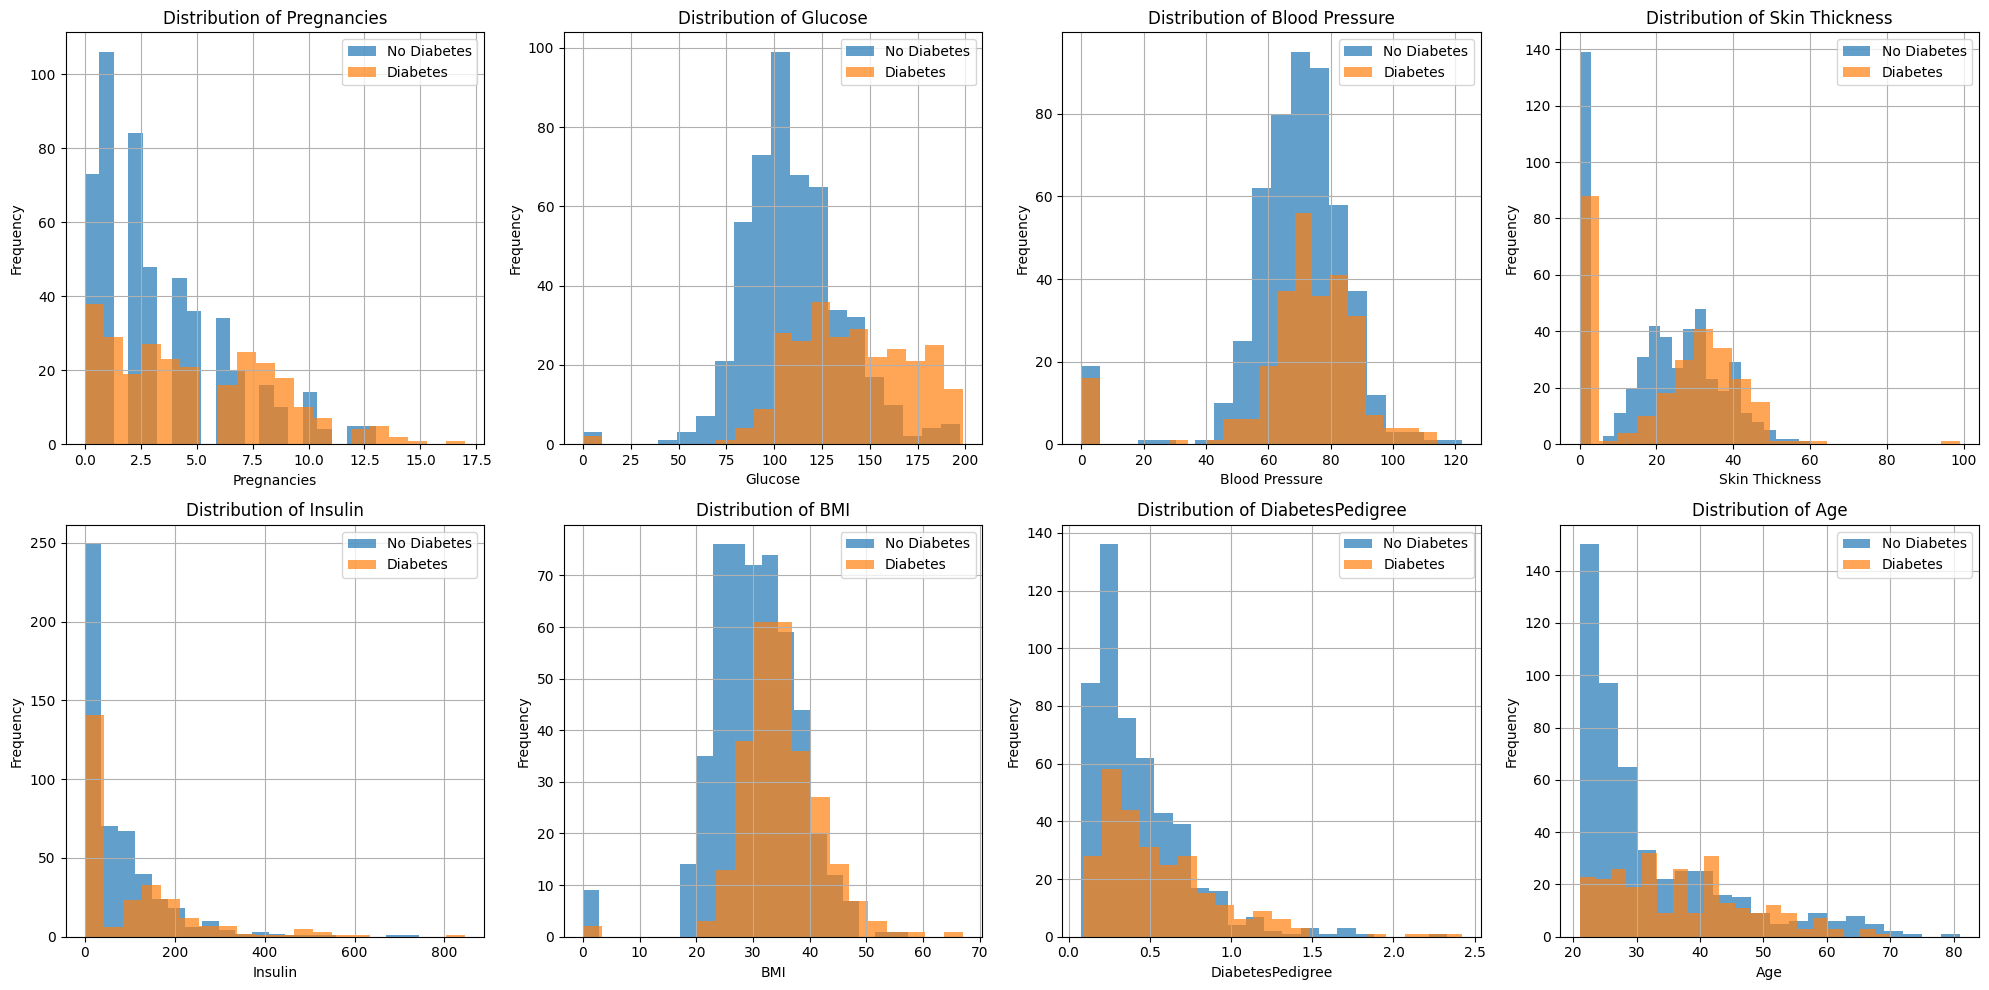

In [17]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()

# Distribution of features by outcome
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

feature_columns = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness',
                  'Insulin', 'BMI', 'DiabetesPedigree', 'Age']

for i, col in enumerate(feature_columns):
    df[df['Outcome'] == 0][col].hist(bins=20, alpha=0.7, label='No Diabetes', ax=axes[i])
    df[df['Outcome'] == 1][col].hist(bins=20, alpha=0.7, label='Diabetes', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features for better logistic regression performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 614
Test set size: 154


In [19]:
print("\n" + "="*60)
print("MULTIVARIABLE LOGISTIC REGRESSION (ALL FEATURES)")
print("="*60)

# Fit logistic regression with all features
lr_full = LogisticRegression(random_state=42, max_iter=1000)
lr_full.fit(X_train_scaled, y_train)

# Make predictions
y_pred_full = lr_full.predict(X_test_scaled)
y_pred_proba_full = lr_full.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_full = accuracy_score(y_test, y_pred_full)
print(f"Accuracy with all features: {accuracy_full:.4f}")

print("\nClassification Report (All Features):")
print(classification_report(y_test, y_pred_full))

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_full.coef_[0],
    'Abs_Coefficient': np.abs(lr_full.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance)


MULTIVARIABLE LOGISTIC REGRESSION (ALL FEATURES)
Accuracy with all features: 0.7143

Classification Report (All Features):
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


Feature Importance (Logistic Regression Coefficients):
            Feature  Coefficient  Abs_Coefficient
1           Glucose     1.144151         1.144151
5               BMI     0.713893         0.713893
0       Pregnancies     0.373178         0.373178
6  DiabetesPedigree     0.255527         0.255527
2    Blood Pressure    -0.197637         0.197637
7               Age     0.184179         0.184179
4           Insulin    -0.127308         0.127308
3    Skin Thickness     0.066535         0.066535


In [22]:
print("\n" + "="*60)
print("FINDING MOST PREDICTIVE SINGLE VARIABLE")
print("="*60)

single_var_results = []

for feature in X.columns:
    # Scale single feature
    X_train_single = scaler.fit_transform(X_train[[feature]])
    X_test_single = scaler.transform(X_test[[feature]])

    # Fit logistic regression
    lr_single = LogisticRegression(random_state=42, max_iter=1000)
    lr_single.fit(X_train_single, y_train)

    # Predict and evaluate
    y_pred_single = lr_single.predict(X_test_single)
    accuracy_single = accuracy_score(y_test, y_pred_single)

    single_var_results.append({
        'Feature': feature,
        'Accuracy': accuracy_single,
        'Coefficient': lr_single.coef_[0][0]
    })

# Sort by accuracy
single_var_df = pd.DataFrame(single_var_results).sort_values('Accuracy', ascending=False)
print("Single Variable Performance:")
print(single_var_df)

best_single_var = single_var_df.iloc[0]['Feature']
best_single_accuracy = single_var_df.iloc[0]['Accuracy']

print(f"\nMost predictive single variable: {best_single_var}")
print(f"Accuracy: {best_single_accuracy:.4f}")


FINDING MOST PREDICTIVE SINGLE VARIABLE
Single Variable Performance:
            Feature  Accuracy  Coefficient
1           Glucose  0.707792     1.243159
0       Pregnancies  0.681818     0.429588
6  DiabetesPedigree  0.675325     0.337379
2    Blood Pressure  0.649351     0.183524
3    Skin Thickness  0.649351     0.196549
7               Age  0.636364     0.495604
4           Insulin  0.629870     0.333415
5               BMI  0.623377     0.764572

Most predictive single variable: Glucose
Accuracy: 0.7078


In [23]:
print("\n" + "="*60)
print("FINDING MOST PREDICTIVE PAIR OF VARIABLES")
print("="*60)

pair_results = []

# Test all possible pairs of features
for feature_pair in combinations(X.columns, 2):
    # Scale feature pair
    X_train_pair = scaler.fit_transform(X_train[list(feature_pair)])
    X_test_pair = scaler.transform(X_test[list(feature_pair)])

    # Fit logistic regression
    lr_pair = LogisticRegression(random_state=42, max_iter=1000)
    lr_pair.fit(X_train_pair, y_train)

    # Predict and evaluate
    y_pred_pair = lr_pair.predict(X_test_pair)
    accuracy_pair = accuracy_score(y_test, y_pred_pair)

    pair_results.append({
        'Feature_Pair': f"{feature_pair[0]} + {feature_pair[1]}",
        'Accuracy': accuracy_pair,
        'Feature1': feature_pair[0],
        'Feature2': feature_pair[1]
    })

# Sort by accuracy and show top 10
pair_df = pd.DataFrame(pair_results).sort_values('Accuracy', ascending=False)
print("Top 10 Variable Pairs Performance:")
print(pair_df.head(10))

best_pair = pair_df.iloc[0]
best_pair_accuracy = best_pair['Accuracy']

print(f"\nMost predictive pair: {best_pair['Feature_Pair']}")
print(f"Accuracy: {best_pair_accuracy:.4f}")

# DETAILED ANALYSIS OF BEST MODELS

print("\n" + "="*60)
print("DETAILED ANALYSIS OF BEST MODELS")
print("="*60)

# Re-train best single variable model for detailed analysis
X_train_best_single = scaler.fit_transform(X_train[[best_single_var]])
X_test_best_single = scaler.transform(X_test[[best_single_var]])

lr_best_single = LogisticRegression(random_state=42, max_iter=1000)
lr_best_single.fit(X_train_best_single, y_train)
y_pred_best_single = lr_best_single.predict(X_test_best_single)
y_pred_proba_best_single = lr_best_single.predict_proba(X_test_best_single)[:, 1]

# Re-train best pair model for detailed analysis
best_features = [best_pair['Feature1'], best_pair['Feature2']]
X_train_best_pair = scaler.fit_transform(X_train[best_features])
X_test_best_pair = scaler.transform(X_test[best_features])

lr_best_pair = LogisticRegression(random_state=42, max_iter=1000)
lr_best_pair.fit(X_train_best_pair, y_train)
y_pred_best_pair = lr_best_pair.predict(X_test_best_pair)
y_pred_proba_best_pair = lr_best_pair.predict_proba(X_test_best_pair)[:, 1]


FINDING MOST PREDICTIVE PAIR OF VARIABLES
Top 10 Variable Pairs Performance:
                         Feature_Pair  Accuracy        Feature1  \
10                      Glucose + BMI  0.714286         Glucose   
12                      Glucose + Age  0.714286         Glucose   
5      Pregnancies + DiabetesPedigree  0.707792     Pregnancies   
0               Pregnancies + Glucose  0.707792     Pregnancies   
11         Glucose + DiabetesPedigree  0.707792         Glucose   
7            Glucose + Blood Pressure  0.707792         Glucose   
9                   Glucose + Insulin  0.707792         Glucose   
1        Pregnancies + Blood Pressure  0.681818     Pregnancies   
16  Blood Pressure + DiabetesPedigree  0.675325  Blood Pressure   
2        Pregnancies + Skin Thickness  0.668831     Pregnancies   

            Feature2  
10               BMI  
12               Age  
5   DiabetesPedigree  
0            Glucose  
11  DiabetesPedigree  
7     Blood Pressure  
9            Insulin  


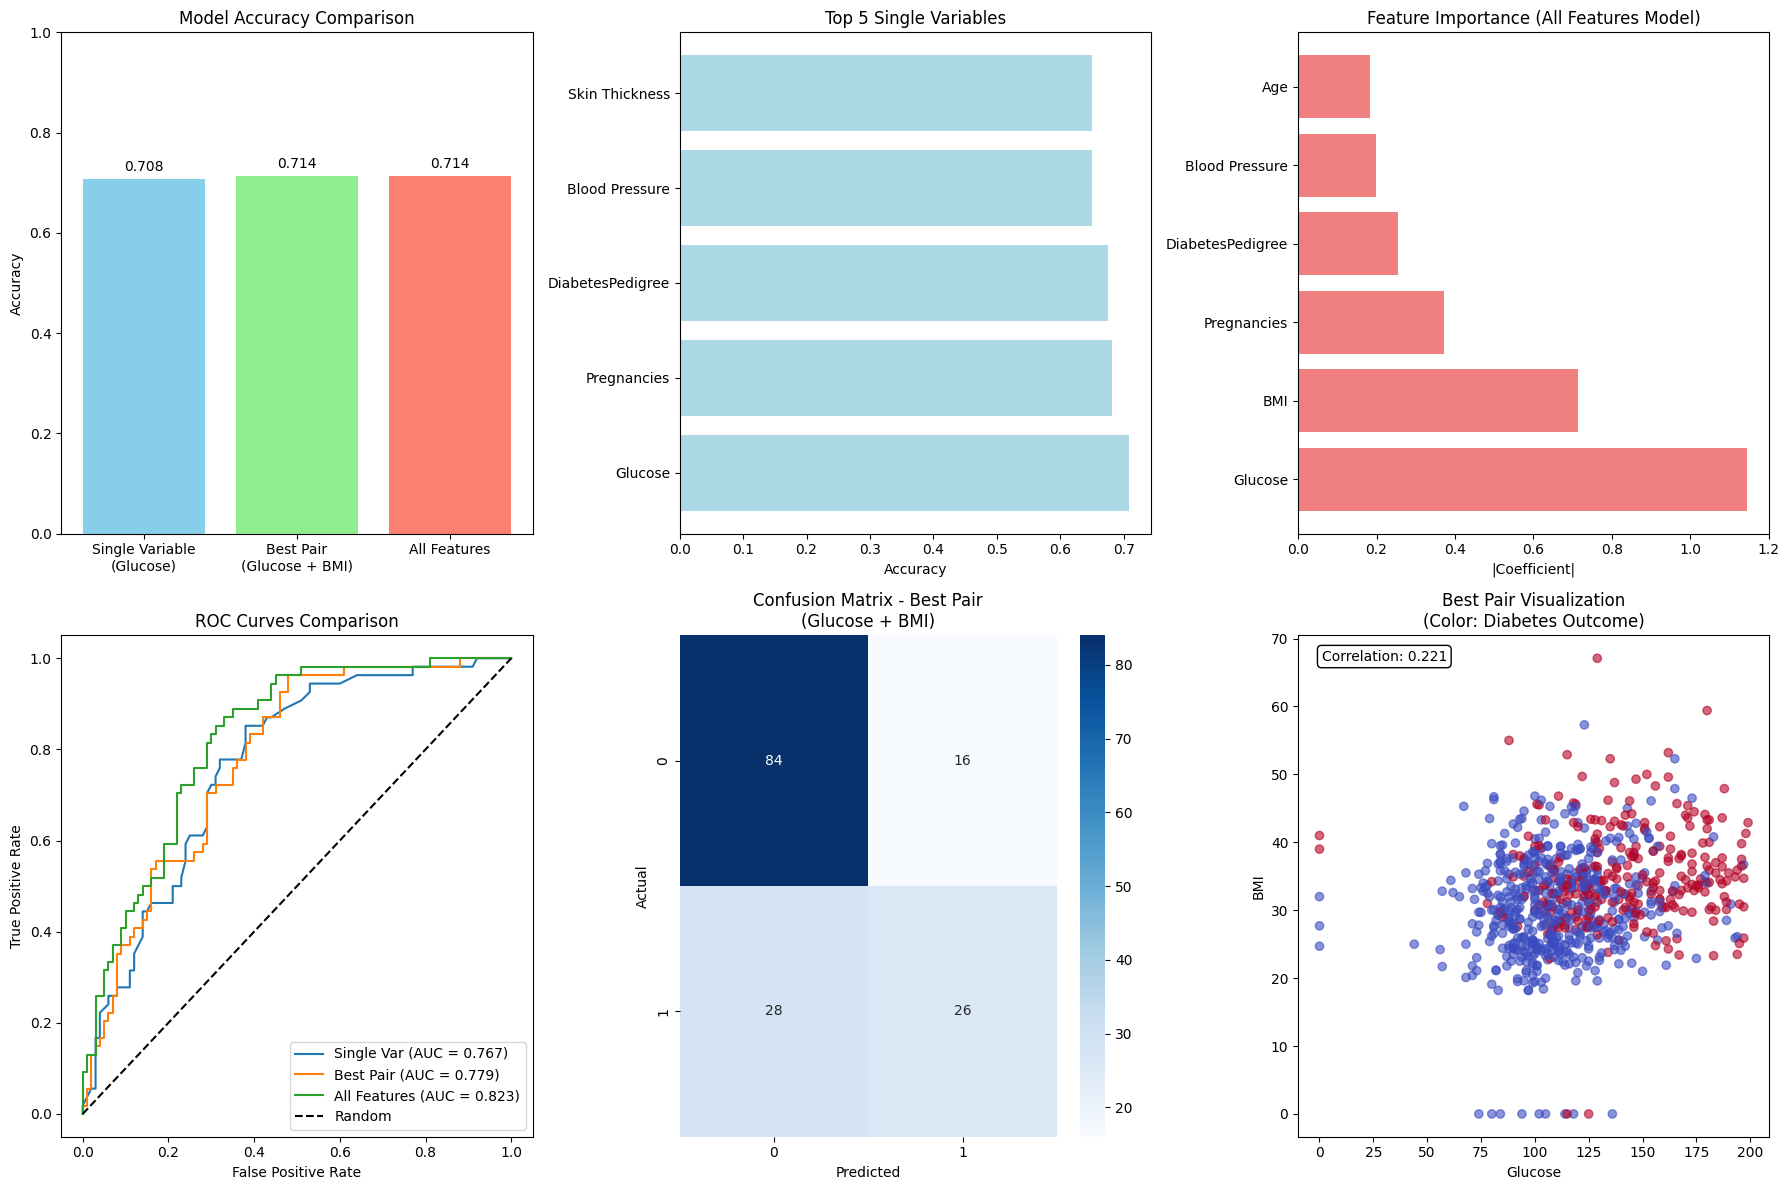

In [24]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model Comparison
models = ['Single Variable\n(' + best_single_var + ')',
          'Best Pair\n(' + best_pair['Feature_Pair'] + ')',
          'All Features']
accuracies = [best_single_accuracy, best_pair_accuracy, accuracy_full]

axes[0, 0].bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. Single Variable Performance
top_5_single = single_var_df.head(5)
axes[0, 1].barh(top_5_single['Feature'], top_5_single['Accuracy'], color='lightblue')
axes[0, 1].set_title('Top 5 Single Variables')
axes[0, 1].set_xlabel('Accuracy')

# 3. Feature Importance (All Features Model)
top_features = feature_importance.head(6)
axes[0, 2].barh(top_features['Feature'], top_features['Abs_Coefficient'], color='lightcoral')
axes[0, 2].set_title('Feature Importance (All Features Model)')
axes[0, 2].set_xlabel('|Coefficient|')

# 4. ROC Curves
fpr_single, tpr_single, _ = roc_curve(y_test, y_pred_proba_best_single)
fpr_pair, tpr_pair, _ = roc_curve(y_test, y_pred_proba_best_pair)
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_proba_full)

auc_single = auc(fpr_single, tpr_single)
auc_pair = auc(fpr_pair, tpr_pair)
auc_full = auc(fpr_full, tpr_full)

axes[1, 0].plot(fpr_single, tpr_single, label=f'Single Var (AUC = {auc_single:.3f})')
axes[1, 0].plot(fpr_pair, tpr_pair, label=f'Best Pair (AUC = {auc_pair:.3f})')
axes[1, 0].plot(fpr_full, tpr_full, label=f'All Features (AUC = {auc_full:.3f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()

# 5. Confusion Matrix - Best Pair Model
cm_pair = confusion_matrix(y_test, y_pred_best_pair)
sns.heatmap(cm_pair, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix - Best Pair\n({best_pair["Feature_Pair"]})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# 6. Correlation of Best Pair
if len(best_features) == 2:
    axes[1, 2].scatter(df[best_features[0]], df[best_features[1]],
                      c=df['Outcome'], cmap='coolwarm', alpha=0.6)
    axes[1, 2].set_xlabel(best_features[0])
    axes[1, 2].set_ylabel(best_features[1])
    axes[1, 2].set_title(f'Best Pair Visualization\n(Color: Diabetes Outcome)')

    # Add correlation coefficient
    corr_coef = df[best_features].corr().iloc[0, 1]
    axes[1, 2].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}',
                   transform=axes[1, 2].transAxes, bbox=dict(boxstyle="round", facecolor='white'))

plt.tight_layout()
plt.show()

In [25]:
print("\n" + "="*60)
print("FINAL SUMMARY REPORT")
print("="*60)

print(f"""
DIABETES PREDICTION MODEL ANALYSIS
===================================

Dataset Information:
- Total samples: {len(df)}
- Features: {len(X.columns)}
- Diabetes prevalence: {df['Outcome'].mean():.1%}

Model Performance Comparison:
-----------------------------
1. Most Predictive Single Variable: {best_single_var}
   - Accuracy: {best_single_accuracy:.4f}
   - AUC: {auc_single:.4f}

2. Most Predictive Variable Pair: {best_pair['Feature_Pair']}
   - Accuracy: {best_pair_accuracy:.4f}
   - AUC: {auc_pair:.4f}

3. All Features Model:
   - Accuracy: {accuracy_full:.4f}
   - AUC: {auc_full:.4f}

Key Insights:
-------------
- The best single predictor is {best_single_var}
- Adding a second variable ({best_features[1]}) improves accuracy by {(best_pair_accuracy - best_single_accuracy):.4f}
- Using all features {'improves' if accuracy_full > best_pair_accuracy else 'does not significantly improve'} performance compared to the best pair

Feature Importance Ranking (All Features Model):
{feature_importance.to_string(index=False)}
""")

print("\nModel Coefficients and Interpretation:")
print("=====================================")
print(f"Best Single Variable Model ({best_single_var}):")
print(f"  Intercept: {lr_best_single.intercept_[0]:.4f}")
print(f"  Coefficient: {lr_best_single.coef_[0][0]:.4f}")

print(f"\nBest Pair Model ({best_pair['Feature_Pair']}):")
print(f"  Intercept: {lr_best_pair.intercept_[0]:.4f}")
for i, feature in enumerate(best_features):
    print(f"  {feature}: {lr_best_pair.coef_[0][i]:.4f}")

print(f"\nAll Features Model:")
print(f"  Intercept: {lr_full.intercept_[0]:.4f}")
for i, feature in enumerate(X.columns):
    print(f"  {feature}: {lr_full.coef_[0][i]:.4f}")


FINAL SUMMARY REPORT

DIABETES PREDICTION MODEL ANALYSIS

Dataset Information:
- Total samples: 768
- Features: 8
- Diabetes prevalence: 34.9%

Model Performance Comparison:
-----------------------------
1. Most Predictive Single Variable: Glucose
   - Accuracy: 0.7078
   - AUC: 0.7672

2. Most Predictive Variable Pair: Glucose + BMI
   - Accuracy: 0.7143
   - AUC: 0.7793

3. All Features Model:
   - Accuracy: 0.7143
   - AUC: 0.8230

Key Insights:
-------------
- The best single predictor is Glucose
- Adding a second variable (BMI) improves accuracy by 0.0065
- Using all features does not significantly improve performance compared to the best pair

Feature Importance Ranking (All Features Model):
         Feature  Coefficient  Abs_Coefficient
         Glucose     1.144151         1.144151
             BMI     0.713893         0.713893
     Pregnancies     0.373178         0.373178
DiabetesPedigree     0.255527         0.255527
  Blood Pressure    -0.197637         0.197637
          